# Manipulating expression trees

## Structure of complex expressions

Recall from the previous notebook that we want to know how Julia represents a complex expression with more than one operation, e.g.:

In [1]:
ex = :(x + y * z)

:(x + y * z)

As usual, we can use `dump` to see the structure:

In [2]:
dump(ex)

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol +
    2: Symbol x
    3: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol *
        2: Symbol y
        3: Symbol z


We see that indeed we have *one `Expr` object embedded into another!* That is, one of the `args` of the top-level expression `ex` is *another* object of type `Expr`:

In [3]:
ex.args[3]

:(y * z)

In [4]:
typeof(ex.args[3])

Expr

We can say that the `Expr` type in Julia is a [**recursive data type**](https://en.wikipedia.org/wiki/Recursive_data_type#:~:text=In%20computer%20programming%20languages%2C%20a,usually%20viewed%20as%20directed%20graphs.): an object of type `Expr` can contain other `Expr` objects! This is another good reason why the type of the `args` field is a vector of `Any`!

This fact has important implications for how we need to work with `Expr` objects.

Another example is an assignment:

In [5]:
dump( :(x = y + z) )

Expr
  head: Symbol =
  args: Array{Any}((2,))
    1: Symbol x
    2: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol +
        2: Symbol y
        3: Symbol z


As we have seen, any piece of code that is more complicated than a single function call has a **hierarchical**, or **nested** structure, with `Expr`s contained inside other `Expr`s. In this section we will see how to manipulate such structures. It is common to think of them as **trees**, called **abstract syntax trees** or **ASTs**, or **computational graphs**.

There are several packages that enable us to visualise an expression as a tree, for example the `TreeView.jl` package that I wrote, and [GraphRecipes.jl](https://github.com/JuliaPlots/GraphRecipes.jl).

In [6]:
# using Pkg; Pkg.add("TreeView")

In [7]:
using TreeView

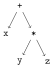

In [8]:
@tree x + y * z

Each internal node of the graph corresponds to a new `Expr`.

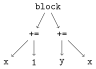

In [9]:
ex = quote
    x += 1
    y += x
end

ex = Base.remove_linenums!(ex)

TreeView.walk_tree(ex)

## Walking through expression trees

Since complex expressions have a **recursive** structure, we need to take this into account when we process them.
As a simple example, let's try to solve the following problems:

> Given an expression, substitute `y` for `x`, i.e. replace each `x` in the expression with a `y`.

The easiest way to do this is to *modify* the expression.

How can we do this? We will need to check each argument to see if it's an `:x`. If it is, we replace it; if not, we move on:

## Exercise

1. Write a function `substitute!` that takes an expression and replaces each `:x` with `:y`.

2. Test it on the expression `x + x * y`. Does it work correctly? If not, what is it missing?

[Deliberately blank!]

In [10]:
function substitute!(ex::Expr, repl_rule=:x => :z)
    args = ex.args  # for ease
    
    for ix ∈ 1:length(args)
        if args[ix] == :x
            args[ix] = :y
            
        elseif args[ix] isa Expr
            substitute!(args[ix])
        
        elseif args[ix] isa Symbol
            substitute!(args[ix], repl_rule) 
        else
            throw(ArgumentError("$(args[ix]) of type $(typeof(args[ix])) not yet supported"))
        end
    end
    
    return ex
end

function substitute!(ex::Symbol, repl_rule=:x => :z)
    ex == repl_rule[1] ? repl_rule[2] : ex
end

substitute! (generic function with 4 methods)

In [11]:
substitute!(:x)

:z

In [12]:
substitute!(:y)

:y

In [13]:
substitute!(:(x + y))

:(y + y)

In [14]:
substitute!(:(x + :x - y))
# ArgumentError: :x of type QuoteNode not yet supported

LoadError: ArgumentError: :x of type QuoteNode not yet supported

In [15]:
ex = :(x + x * y)

:(x + x * y)

In [16]:
substitute!(ex)

:(y + y * y)

Now *all* `x`s were successfully replaced! But note that the original expression has been lost:

In [17]:
ex

:(y + y * y)

Although the code is *easier to write* using mutation (since otherwise we need to build up a similar expression with the same structure, which is possible but trickier), users probably don't expect or want their expression to be mutated, since you cannot then recover the original expression, which you might need later. It is common to then provide a *non-mutating* version, by making a copy of the original expression and mutating that.

In [18]:
substitute(ex) = deepcopy(ex) |> substitute!

substitute (generic function with 1 method)

In [19]:
ex = :(x + x * y)

:(x + x * y)

In [20]:
substitute(ex)

:(y + y * y)

The original expression has now not changed:

In [21]:
ex

:(x + x * y)

Note that it would have been tempting to write this by iterating over the arguments using `for arg in ex.args ...`, but that will *not* work, since you then *cannot* modify the resulting argument in place within the expression &ndash; `arg` is a *copy* of the immutable object inside the expression, rather than a *reference* to it:

In [22]:
ex = :(x + y)

:(x + y)

In [23]:
for arg ∈ ex.args
    @show arg, typeof(arg)
    arg = :z
end

(arg, typeof(arg)) = (:+, Symbol)
(arg, typeof(arg)) = (:x, Symbol)
(arg, typeof(arg)) = (:y, Symbol)


In [24]:
ex

:(x + y)

## Exercise

1. Make the `substitute` function more general, by specifying what to substitute with what

In [25]:
## done - limited to 1 rule though

## Exercise

1. Find which variables are used inside an expression

   For example, the expression `2x + y * x - 1` should return the vector `[x, y]`, removing duplicates.
   
   Hint: This requires returning the vector of variables.


[Deliberately blank]

In [40]:
"""
  find_vars find the variable inside the expression
  variable are supposed to be only alphabetical chars upcase/lowcase
"""
function find_vars(expr)
    s = Set{Any}()
    s = _find_vars(expr, s)
    Vector{Any}(collect(s)) |> sort
end

_find_vars(expr::Number, s::Set)::Set = s

_find_vars(expr::Symbol, s::Set)::Set = 
  match(r"\A[a-zA-Z]+\z", string(expr)) !== nothing ? push!(s, expr) : s

function _find_vars(expr::Expr, s::Set)::Set
    for arg ∈ expr.args
        _find_vars(arg, s)
    end
    s
end

_find_vars (generic function with 3 methods)

In [41]:
find_vars(:(2x + y * x - 1))

2-element Vector{Any}:
 :x
 :y

In [42]:
find_vars(:(2 + y * x - 1))

2-element Vector{Any}:
 :x
 :y

In [43]:
find_vars(:(2 + y))

1-element Vector{Any}:
 :y

In [44]:
find_vars(:((2 + y) * (x - 3) / (z - x)))

3-element Vector{Any}:
 :x
 :y
 :z

In [45]:
find_vars(:(x + x * y))

2-element Vector{Any}:
 :x
 :y

In [46]:
find_vars(:(z = x * y))

3-element Vector{Any}:
 :x
 :y
 :z

**Remark**  
But first let's remark that it is usually an **anti-pattern** to use `isa` in Julia! [Recall that `x isa T` tests if the object `x` has type `T`.]
This should usually be replaced by **dispatch**! We can rewrite the same code as follows:

In [47]:
# find_variables(x::Symbol) = [x]
# find_variables(x::Real) = []
# find_variables(x::Expr) = sort(unique(reduce(vcat, find_variables(arg) for arg in x.args[2:end])))

## Quote blocks

For longer pieces of code it is common to use `quote ... end` instead of `:( ... )`:

In [48]:
ex = quote
    x += 1
    y += x
end

quote
    #= In[48]:2 =#
    x += 1
    #= In[48]:3 =#
    y += x
end

Note that quote blocks automatically embed line number information telling you where that piece of code was created, for debugging purposes.
We can remove that with `Base.remove

In [49]:
Base.remove_linenums!(ex)

quote
    x += 1
    y += x
end

In [50]:
dump( Base.remove_linenums!(ex) )

Expr
  head: Symbol block
  args: Array{Any}((2,))
    1: Expr
      head: Symbol +=
      args: Array{Any}((2,))
        1: Symbol x
        2: Int64 1
    2: Expr
      head: Symbol +=
      args: Array{Any}((2,))
        1: Symbol y
        2: Symbol x


The only new feature here is that a quote **block** is a new type of `Expr` with `head` equal to `:block`.

## Futher exercises

1. Given an expression, wrap all the literal values (numbers) in the expression with a wrapper type.

2. Replace each of `+`, `-`, `*` and `/` with the corresponding **checked** operation, which checks for overflow. E.g. `+` should be replaced by `Base.checked_add`.